(array([-36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24,
        -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11,
        -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
         16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36]),
 array([0.02601979, 0.05198932, 0.08685713, 0.11515767, 0.14243588,
        0.1690697 , 0.19494538, 0.2186137 , 0.24912034, 0.2711147 ,
        0.2913767 , 0.31185257, 0.3356944 , 0.3550602 , 0.37258306,
        0.38863143, 0.40487498, 0.42652568, 0.44522515, 0.46621567,
        0.48429364, 0.50254214, 0.52172184, 0.5426069 , 0.56222165,
        0.58265376, 0.60757977, 0.6377448 , 0.6714545 , 0.70647126,
        0.744268  , 0.7878378 , 0.82640874, 0.86878425, 0.9163864 ,
        0.9566499 , 0.9952344 , 0.96472806, 0.93416417, 0.89158857,
        0.8532778 , 0.81814003, 0.7800299

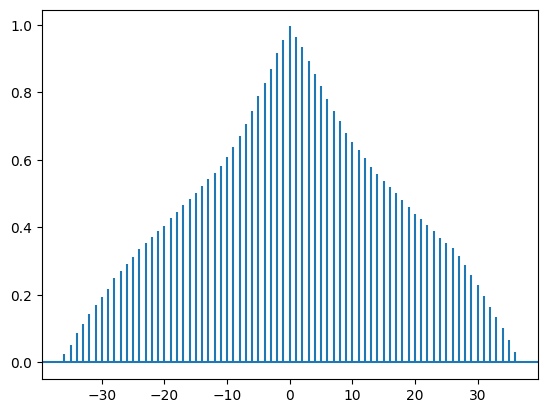

In [19]:
plt.xcorr(velocity, discharge, maxlags=None)

-10 27 27
-9 28 28
-8 29 29
-7 30 30
-6 31 31
-5 32 32
-4 33 33
-3 34 34
-2 35 35
-1 36 36
0 37 37
1 36 36
2 35 35
3 34 34
4 33 33
5 32 32
6 31 31
7 30 30
8 29 29
9 28 28
10 27 27


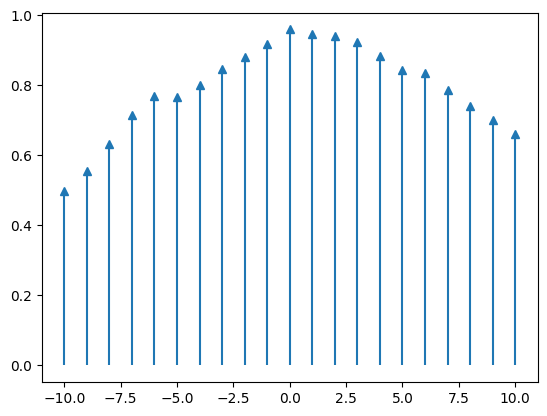

In [79]:
import scipy.signal as signal
import numpy as np
from scipy.stats import pearsonr


def xcorr(x, y):
    """
    Perform Cross-Correlation on x and y
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    corr : coefficients of correlation
    """
    corr = signal.correlate(x, y, mode="full")
    lags = signal.correlation_lags(len(x), len(y), mode="full")

    norm_factor = np.sqrt(np.sum(y**2) * np.sum(y**2))
    corr /= norm_factor
    return lags, corr


def xcorr_lags(x, y):
    """
    Compute Pearson correlation coefficients for different lags.
    x    : 1st signal
    y    : 2nd signal

    returns
    lags : lags of correlation
    c    : Pearson correlation coefficients for each lag
    """
    lags = signal.correlation_lags(len(x), len(y), mode="full")
    lags = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    r2 = np.zeros_like(lags, dtype=float)
    p = np.zeros_like(lags, dtype=float)
    psig = np.zeros_like(lags, dtype=str)

    for i, lag in enumerate(lags):
        y_shifted = y.shift(time=lag)

        mask = x.notnull() & y_shifted.notnull()
        x_masked = x.where(mask, drop=True)
        y_shifted = y_shifted.where(mask, drop=True)
        print(lag, len(x_masked), len(y_shifted))

        res = scipy.stats.linregress(x_masked, y_shifted)
        r2[i] = res.rvalue
        p[i] = res.pvalue
        psig[i] = "sig" if res.pvalue < 0.05 else "notsig"

    return lags, r2, p, psig


discharge = xr.open_dataset("../data/discharge/discharge_monthly_1986_2024.nc")
discharge = discharge.discharge.sel(glacier="UNNAMED_UUNARTIT_ISLANDS")
discharge = discharge.resample(time="1YS").mean()

vel = xr.open_dataset("../data/velocity/velocity_subannual_1985_2022.nc")
vel = vel.rename(mid_date="time")
vel = vel.sel(glacier="UNNAMED_UUNARTIT_ISLANDS", cd=1_000)
vel = vel.where(vel.date_dt.dt.days <= 30, drop=True)
velocity = vel.sortby("time").v.resample(time="1MS").mean().squeeze()
velocity = velocity.resample(time="1YS").mean().squeeze()

mask = velocity.notnull() & discharge.notnull()
velocity = velocity.where(mask, drop=True)
discharge = discharge.where(mask, drop=True)

lags, r2, p, psig = xcorr_lags(velocity, discharge)

plt.figure()
for lag_val, r2_val, psig_val in zip(lags, r2, psig):
    marker = "^" if psig_val == "s" else "o"
    plt.stem(lag_val, r2_val, markerfmt=marker)

# plt.stem(lags, r2)
plt.show()

In [74]:
list(zip(lags, r2, p, psig))

[(-10, 0.49679648624025247, 0.00838705801720375, 's'),
 (-9, 0.5548072571027407, 0.0021831695898569805, 's'),
 (-8, 0.6326590001810944, 0.00023087146895720424, 's'),
 (-7, 0.7135830371440879, 9.564376113253013e-06, 's'),
 (-6, 0.7686794782231364, 4.405846530503383e-07, 's'),
 (-5, 0.7649452089716601, 3.431363663494036e-07, 's'),
 (-4, 0.8020445805754869, 2.007649307534781e-08, 's'),
 (-3, 0.8473725459057754, 2.6061870990079614e-10, 's'),
 (-2, 0.8809901816812904, 2.920141784845723e-12, 's'),
 (-1, 0.9185609177889327, 2.900253879329367e-15, 's'),
 (0, 0.9591056946273385, 9.0998344639309e-21, 's'),
 (1, 0.9469974733287322, 2.440811882861457e-18, 's'),
 (2, 0.9404717919824869, 4.9869895746685496e-17, 's'),
 (3, 0.9238100339668375, 6.841966779127436e-15, 's'),
 (4, 0.8837029451316767, 9.590415305310327e-12, 's'),
 (5, 0.8445025802385194, 1.235634714805686e-09, 's'),
 (6, 0.8354461498704746, 5.0109836643483724e-09, 's'),
 (7, 0.7869755706996644, 2.498537271847706e-07, 's'),
 (8, 0.739719327

In [36]:
velocity

<xarray.DataArray 'v' (time: 37)> Size: 148B
array([2514.786 , 2492.5   , 2986.9688, 2455.111 , 2437.75  , 2290.    ,
       2557.3582, 2390.1667, 3184.8333, 2486.9583, 2337.625 , 2531.65  ,
       2983.7083, 2455.2776, 2455.923 , 2399.55  , 2437.075 , 2923.    ,
       2712.2498, 2802.9897, 2644.654 , 2703.3472, 2774.004 , 2964.372 ,
       3014.3928, 3081.9207, 3300.4414, 3719.0933, 4007.547 , 4060.4402,
       4319.9   , 5223.5728, 4778.397 , 5064.83  , 5532.8105, 4824.1953,
       4728.466 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 296B 1986-01-01 1987-01-01 ... 2022-01-01
    cd       int32 4B 1000
    glacier  <U24 96B 'UNNAMED_UUNARTIT_ISLANDS'
    x        float64 8B 4.886e+05
    y        float64 8B -2.427e+06
    gate     int64 8B 207
Attributes:
    description:  median velocity magnitude sampled within a 1x1 km box about...
    units:        metre/year

In [35]:
discharge

<xarray.DataArray 'discharge' (time: 37)> Size: 148B
array([2.6503854, 2.7572532, 2.600552 , 2.5143666, 2.4546347, 2.4397535,
       2.9214966, 2.8586068, 2.7618062, 2.7746177, 2.698412 , 2.260447 ,
       2.2410753, 2.593119 , 2.5960348, 2.5666404, 2.6048508, 2.7146492,
       2.743214 , 2.727413 , 2.717431 , 2.7927647, 2.831577 , 2.9953048,
       3.1063387, 3.197833 , 3.318465 , 3.509599 , 3.7576258, 3.8813798,
       4.039388 , 4.569124 , 4.275107 , 4.5185494, 4.6851525, 4.0939193,
       4.065743 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 296B 1986-01-01 1987-01-01 ... 2022-01-01
    gate     int64 8B 207
    x        float64 8B ...
    y        float64 8B ...
    glacier  <U24 96B 'UNNAMED_UUNARTIT_ISLANDS'
    cd       int32 4B 1000
Attributes:
    long_name:      Discharge
    standard_name:  land_ice_mass_tranport_due_to_calving_and_ice_front_melting
    units:          Gt yr-1

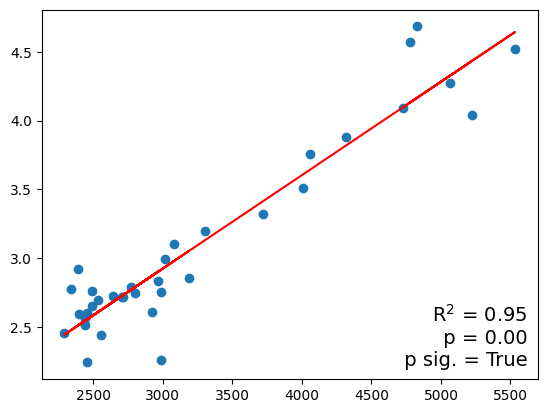

In [42]:
# pearsonr(x[valid_idx], y_shifted[valid_idx])
d = discharge.shift(time=1)

mask = velocity.notnull() & d.notnull()
velocity = velocity.where(mask, drop=True)
d = d.where(mask, drop=True)

res = scipy.stats.linregress(velocity, d)
plt.plot(velocity, d, "o")
plt.plot(velocity, res.intercept + res.slope * velocity, "r", label="fitted line")

plt.gca().add_artist(
    AnchoredText(
        f"R$^{{2}}$ = {res.rvalue:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
        loc="lower right",
        borderpad=0.1,
        prop=dict(fontsize=14, horizontalalignment="right"),
        frameon=False,
    )
)

In [ ]:
list(zip(lags, corr))

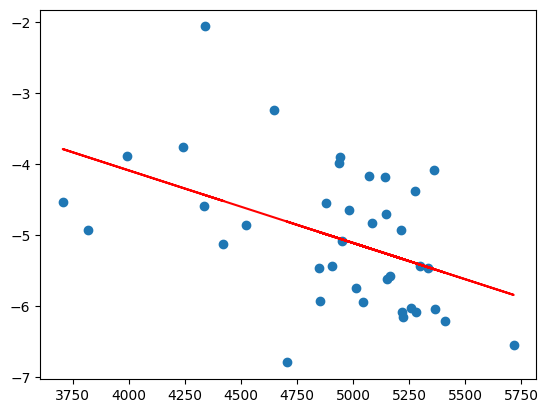

In [20]:
import geopandas as gpd
import pandas as pd

boxes_gdf = gpd.read_file("../data/terminus/terminus_boxes_1985_2023.geojson")
boxes_gdf["date"] = pd.to_datetime(boxes_gdf.date)
x = boxes_gdf.set_index(["date"]).to_xarray()
x = x.where(x.glacier == "DAUGAARD-JENSEN")
x = x.sortby("date")
x["area_width_averaged"] = x.area_width_averaged.astype(float)
baseline = slice("1985-01-01", "2024-01-01")
r_monthly = x.area_width_averaged.resample(date="1MS").mean()
r_baseline = r_monthly.sel(date=baseline).groupby("date.month").mean()
r_anomalies = r_monthly.groupby("date.month") - r_baseline

air = xr.open_dataset("../data/air/air_temp_monthly_1980_2024.nc")
air = air.sel(glacier="DAUGAARD-JENSEN")
air = air.sel(time=slice(r_monthly.date.min().values, r_monthly.date.max().values))

r_monthly = r_monthly.rename(date="time")

r_monthly = r_monthly.resample(time="1YS").mean()
air = air.t_monthly.resample(time="1YS").mean()

mask = ~np.isnan(air) & ~np.isnan(r_monthly)
air = air.where(mask, drop=True)
r_monthly = r_monthly.where(mask, drop=True)

res = scipy.stats.linregress(r_monthly, air)
plt.plot(r_monthly, air, "o")
plt.plot(r_monthly, res.intercept + res.slope * r_monthly, "r", label="fitted line")

In [21]:
res

LinregressResult(slope=-0.0010217840546969104, intercept=-0.000845127501528431, rvalue=-0.4671364024175323, pvalue=0.0031084673079739265, stderr=0.0003223349753035718, intercept_stderr=1.5912778998618946)

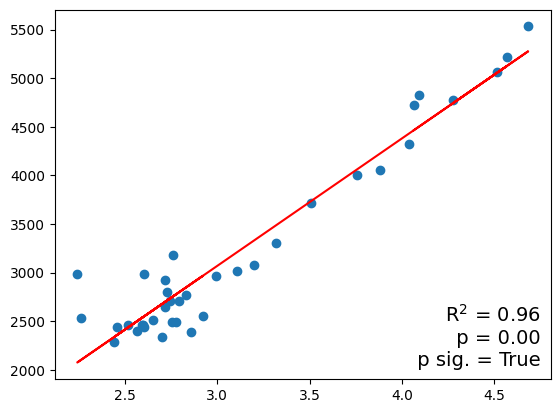

In [12]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from matplotlib.offsetbox import AnchoredText

discharge = xr.open_dataset("../data/discharge/discharge_monthly_1986_2024.nc")
discharge = discharge.discharge.sel(glacier="UNNAMED_UUNARTIT_ISLANDS")
discharge = discharge.resample(time="1YS").mean()

vel = xr.open_dataset("../data/velocity/velocity_subannual_1985_2022.nc")
vel = vel.rename(mid_date="time")
vel = vel.sel(glacier="UNNAMED_UUNARTIT_ISLANDS", cd=1_000)
vel = vel.where(vel.date_dt.dt.days <= 30, drop=True)
velocity = vel.sortby("time").v.resample(time="1MS").mean().squeeze()
velocity = velocity.resample(time="1YS").mean().squeeze()

mask = velocity.notnull() & discharge.notnull()
velocity = velocity.where(mask, drop=True)
discharge = discharge.where(mask, drop=True)

res = scipy.stats.linregress(discharge, velocity)
plt.plot(discharge, velocity, "o")
plt.plot(discharge, res.intercept + res.slope * discharge, "r", label="fitted line")

plt.gca().add_artist(
    AnchoredText(
        f"R$^{{2}}$ = {res.rvalue:.2f}\n p = {res.pvalue:.2f}\n p sig. = {res.pvalue < 0.05}",
        loc="lower right",
        borderpad=0.1,
        prop=dict(fontsize=14, horizontalalignment="right"),
        frameon=False,
    )
)

In [30]:
res

LinregressResult(slope=1310.4654062624493, intercept=-862.4036416907975, rvalue=0.9591056946273385, pvalue=9.0998344639309e-21, stderr=65.37104394313349, intercept_stderr=207.83513951426164)

In [18]:
3.0182471435533915e-124

3.0182471435533915e-124